In [1]:
import torch

In [2]:
net = torch.nn.Conv2d(1, 16, 3, 1, (3 -1)//2) ## Convlution with dimension 1, with 16 channels outputs, kernel size 3, no stride and padding of (kernel size - 1)// 2
# stick with Conv1d -> Conv3d, onlyuse LazyConv if needed
# 1D is convolution over a time series over some signal
# 2D if you deal with image data
# 3D if you deal with either volume data or video data that has 3rd dimension to it
# in convolution, there is 2 channels inputs, 2 channels parameters
# 1st is how mahy channles go into convolution, and 2nd is how many channels do we expect convolution to produce
# the inputs and outputs of convolution always with channel heigh width
# kernel size is how large the convolutional kernel is
# stride parameter, how many outputs should we skip if we stride convolution
# padding, as rule of thumb you should always set padding to half the kernel size minus 1
# bias paramerter means do we want to produce bias term for this layer or you don't want to produce bias term


In [4]:
x = torch.randn(1, 1, 28, 28) ## data with batch size 1, channel 1, and size 28 x 28
print(x.shape)

torch.Size([1, 1, 28, 28])


In [ ]:
y = net(x)
print(y.shape) # convolution did not change the size of the output, but it change number of channels in the input


torch.Size([1, 16, 28, 28])


In [ ]:
net = torch.nn.Conv2d(1, 16, 3, 2, (3 - 1)//2) # we stride here
x = torch.randn(1, 1, 28, 28)
print(x.shape)
y = net(x)
print(y.shape) ## the output cut in half because triding we skip every other output

torch.Size([1, 1, 28, 28])
torch.Size([1, 16, 14, 14])


In [14]:
class ConvNet(torch.nn.Module):
    def __init__(self, layers=[16, 32, 64], kernel_size = 3, stride = 1) -> None:
        super().__init__()
        cnn_layers = []
        c1 = 1 # originaly because we have 1 dimensional input
        for c2 in layers: # c2 is the output channels size which it the layers
            cnn_layers.append(torch.nn.Conv2d(c1, c2, kernel_size, stride, (kernel_size - 1)//2)) #add layer with c1 input and c2 output
            cnn_layers.append(torch.nn.ReLU()) # non-linearities in betwwen
            c1 = c2
        cnn_layers.append(torch.nn.Conv2d(c1, 1, kernel_size=1)) # c1 input channels, 1 dimension, kernel size 1, no stride
        # final layer is a classifier
        # 2 ways to add a classifier:
        # 1 - take outputs of the convolutional network then average pull all of it together then apply a classifier
        # 2 - add a 1 x 1 convolution here for matrix multiplication, it applied element wise to all outputs, then would average
        # if averge first and apply classifier for all channel sizes, this computationally cheaper
        # but it is nicer to apply the classifier first, because that way you later can infer what spatial locations correspond to certain classifications
        # if have computational power use 1 x 1 convolution
        self.network = torch.nn.Sequential(*cnn_layers)

    def forward(self, x):
        return self.network(x)

net = ConvNet()
print(net)

ConvNet(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [18]:
net(x).shape

torch.Size([1, 1, 28, 28])

In [19]:
net = ConvNet(stride=2)
net(x).shape

torch.Size([1, 1, 4, 4])

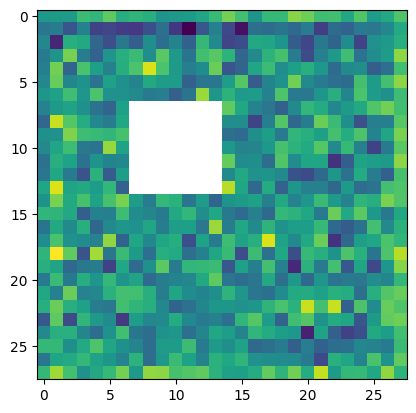

In [ ]:
# receptive fields
from matplotlib import pyplot as plt

x = torch.rand(1, 1, 28, 28)
x[0, 0, 10, 10] = float('inf') # inf will become NaN later
net = ConvNet()
y = net(x)
plt.imshow(y[0, 0].detach().numpy()) #visualize, right now we feed random noise so we get back random noise

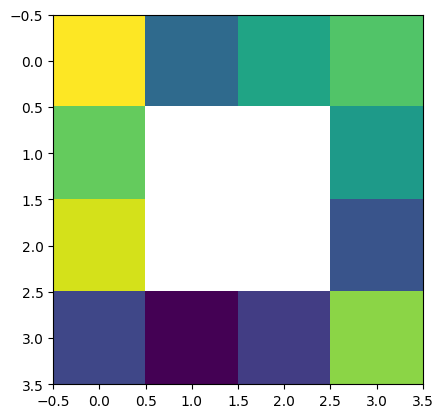

In [22]:
x = torch.rand(1, 1, 28, 28)
x[0, 0, 10, 10] = float('inf')
net = ConvNet(stride=2)
y = net(x)
plt.imshow(y[0, 0].detach().numpy())

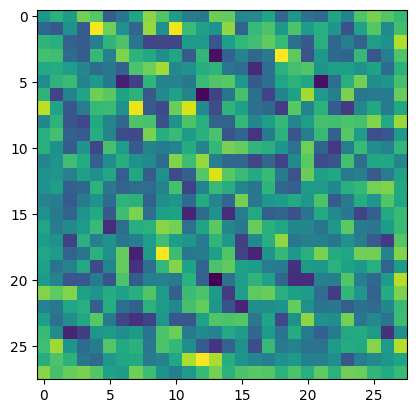

In [24]:
# receptive field
x = torch.rand(1, 1, 28, 28, requires_grad=True)
# x[0, 0, 10, 10] = float('inf')
net = ConvNet()
y = net(x)
y.sum().backward()
plt.imshow(x.grad[0, 0].detach().numpy())

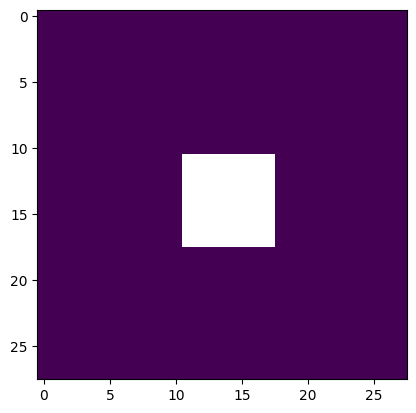

In [27]:
# get receptive field for specific output
x = torch.rand(1, 1, 28, 28, requires_grad=True)
# x[0, 0, 10, 10] = float('inf')
net = ConvNet()
y = net(x)

z = y.new_zeros(y.shape) # create a new tensor of 0 with the same shape as y
z[0, 0, z.shape[2]//2, z.shape[3]//2] = float('NaN') # we set 1 element to NaN

(y * z).sum().backward() # we multiply them together then compute the sum
# the gradient will go backwards through this function
# it will be originally 1, so to sum it will be 1
# and in here the gradient will be multiplied with either a 0 if not the selected element or it will be mutiply by NaN
# now we can ensure that the probe is 0 everywhere except for 1 element

plt.imshow(x.grad[0, 0].detach().numpy())

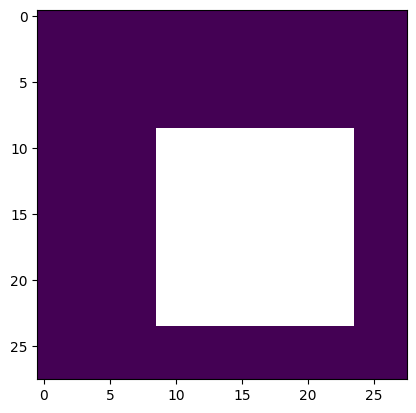

In [ ]:
# get receptive field for specific output
x = torch.rand(1, 1, 28, 28, requires_grad=True)
# x[0, 0, 10, 10] = float('inf')
net = ConvNet(stride=2)
y = net(x)

z = y.new_zeros(y.shape)  # create a new tensor of 0 with the same shape as y
z[0, 0, z.shape[2]//2, z.shape[3]//2] = float('NaN')  # we set 1 element to NaN

(y * z).sum().backward()

plt.imshow(x.grad[0, 0].detach().numpy())

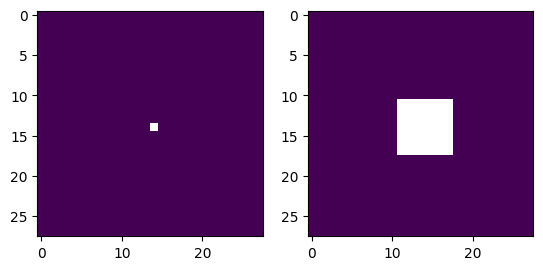

In [ ]:
# get receptive field for specific output
x = torch.rand(1, 1, 28, 28, requires_grad=True)
# x[0, 0, 10, 10] = float('inf')
net = ConvNet(stride=1)
y = net(x)

z = y.new_zeros(y.shape)  # create a new tensor of 0 with the same shape as y
z[0, 0, z.shape[2]//2, z.shape[3]//2] = float('NaN')  # we set 1 element to NaN
f, ax = plt.subplots(1, 2)
ax[0].imshow(z[0, 0].detach().numpy()) # draw the probe, it start in the middle where we decalre z
(y * z).sum().backward()

ax[1].imshow(x.grad[0, 0].detach().numpy())